In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util_xai as util
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Generate synthetic data
data, name_map = util.generate_data(size=500, seed=42)
num_cols = [c for c in data.columns[:-1] if len(data[c].unique()) > 2]
cat_cols = [c for c in data.columns[:-1] if len(data[c].unique()) == 2]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Baseline Approach

## A Baseline Approach

**Our goal is _understading_ the process behind the data**

Of of many possible ways to do it consist in:

* Training an approximate model via Machine Learning
* Studying the model as a proxy for the real process

> **Basically, we use a ML model as an _analysis tool_**

**For this approach to work, we need the ML model to be _explainable_**

* A few model naturally enjoy this property (e.g. linear models, simple DTs)
* Explaining other models is not obvious (e.g. Neural Networks, large ensembles)

We will start with the simplest option: Logistic Regression

## Data Preprocessing

**We start with the usual data preprocessing**

We will treat all candidate correlates as inputs

In [3]:
# Input-output separation
X, y = data[data.columns[:-1]].copy(), data[data.columns[-1]].copy()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Input standardization
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Even if we don't care about estimates, we need a _test/validation set_

* This will allow us to check the model for overfitting

We also need to standardize all numeric features

* This will make the model coefficients more easily interpretable

## On the Danger of Overfitting

**We plan to use our model as proxy for the true process**

...Which makes _overfitting is especially bad_

* Our results will stricly apply only to the model
* ...And they will be as general as the model

**We will use _L1 regularization_ on this purpose**

Scikit learn support L1 regularizers for Logistic Regression in the form:

$$
\mathop{\mathrm{argmin}_\theta} H(y, f(x, \theta)) + \frac{1}{C}\|\theta\|_1
$$

* We encourage the weights to be close to 0
* ...And we attempt to sparsify the weights

## Training our "Proxy" Model

**We can calibrate the $C$ parameter via cross-validation**

We'll need the [SAGA solver](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf) to train our model with L1 regularization

In [4]:
base_est = LogisticRegression(penalty='l1', solver='saga')
param_grid={'C': 1. / np.linspace(1e-1, 1e4, 100)}
gscv = GridSearchCV(base_est, param_grid=param_grid, scoring='roc_auc')
gscv.fit(X_train, y_train)
lr, lr_params = gscv.best_estimator_, gscv.best_params_

**Then we can check the performance of the refitted estimator**

In [5]:
lr_score_cv, lr_score_test = gscv.best_score_, roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print(f'AUC score for C={lr_params["C"]:.2f}: {lr_score_cv:.2f} (cross-validation), {lr_score_test:.2f} (test)')

AUC score for C=10.00: 0.64 (cross-validation), 0.60 (test)


* We use the AUC score, since this is not a deterministic classification problem
* There's no significant overfitting

## Coefficient Analysis

**Finally, we can analyze the model coefficients**

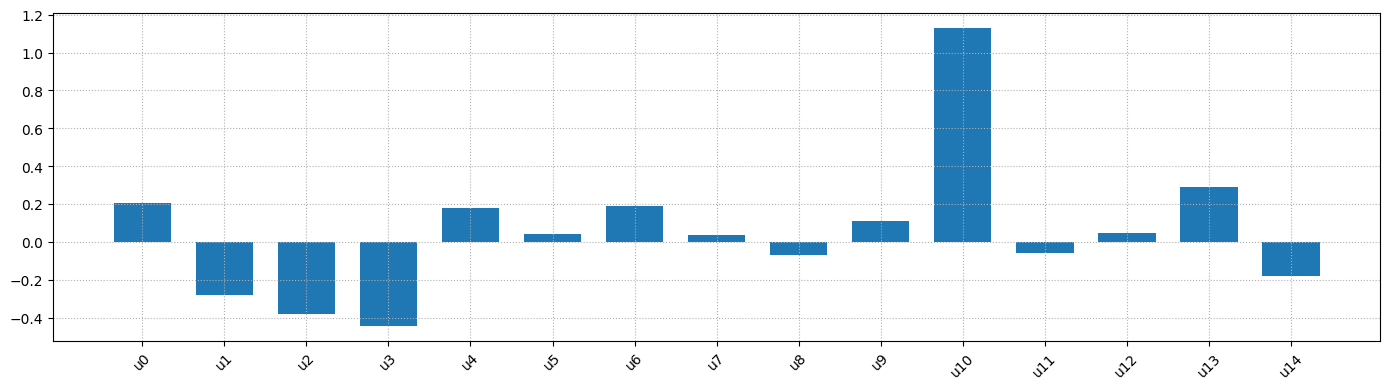

In [6]:
lr_coefs = pd.Series(index=X.columns, data=lr.coef_[0])
util.plot_bars(lr_coefs, figsize=figsize)

* Some variables seem to be more important than others
* The sign tells us how they are linked to the target

<div class=big>
<span class=small>This baseline approach has <i>many</i> issues</span><br>
Can you spot a few ones?
</div>

## Three Key Issues with our Baseline

**Issue 1: our model has _poor accuracy_**

* An AUC score of 0.6 is not much above random
* ...Hence, studying our model will say little about the data

**Issue 2: our model can only capture _linear correlations_**

* We can capture neither non-linear effects
* ...Nor interactions among the variables

**Issue 3: the coefficients are not sparse**

* The L1 terms needs both to sparsify and to prevent overfitting
* ...And it cannot do both things effectively
* Additionally: it's unclear what a good level of sparsification might be

<div class=big>
We'll now get to work to fix them
</div>